In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_op
# from WindPy import *
from functools import reduce
import datetime

In [15]:
np.set_printoptions(precision=2)

### get_data

In [70]:
data=pd.read_excel('./data/value.xlsx')
data.set_index('Date',inplace=True)

In [107]:
tmp=data.loc[(data.index>'2015-01-01')&(data.index<'2017-01-01'),:]
rets=np.log(tmp/tmp.shift(1))
rets.dropna(inplace=True)

In [72]:
rets.head()

,510900.OF,000359.OF,110010.OF,110023.OF,159934.OF,110030.OF,161117.OF,000111.OF
Date,,,,,,,,
2015-01-06,-0.016554,0.000129,0.017301,0.032561,0.007831,0.000291,0.000933,0.000000
2015-01-07,0.000444,0.000128,-0.003811,-0.009195,0.002597,-0.000989,0.000000,0.000000
2015-01-08,0.003190,0.000129,0.000599,0.003842,-0.001607,-0.020935,0.000000,0.000000
2015-01-09,0.004237,0.000155,0.004106,-0.001535,0.000701,-0.001725,0.000000,0.001919
2015-01-12,-0.005654,0.000377,0.012072,0.012214,0.011716,-0.007889,0.001864,0.000000


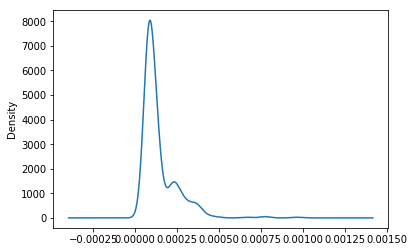

In [110]:
rets.iloc[:,1].plot(kind='kde')

### reference_weights

In [75]:
wage=10
l_wage=10*(1.04**30)
save=3
incre1=1+0.06
incre2=1+0.03
infla=1+0.03
use=15

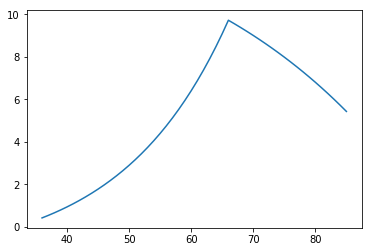

In [76]:
dic_returns={}
years=[]
rates=[]
refer_rates={}
dic_returns[35]=10
for year in range(36,86):
    if year<67:
        dic_returns[year]=dic_returns[year-1]*incre1+save
        rate=dic_returns[year]/l_wage
    else:
        dic_returns[year]=dic_returns[year-1]*incre2-use
        rate=dic_returns[year]/l_wage
    refer_rates[year]=rate
#     print(year,dic_returns[year])
    years.append(year)
    rates.append(rate)
plt.plot(years,rates)

### find_weights

In [91]:
def fun_expected_returns(weights):
    expected_returns=[]
    x1=weights[0:8]
    x2=weights[8:16]
    x3=weights[16:24]
#     print(x3)
    for year in range(35,50):
        return1=[]
        for j in range(252):
            a=np.random.randint(rets.shape[0])
#             print(x1)
#             print(rets.iloc[a,:])
            return1.append(np.sum(x1*rets.iloc[a,:])+1)
        expected_returns.append(np.prod(np.array(return1))-1)
    for year in range(50,75):
        return1=[]
        for j in range(252):
            a=np.random.randint(rets.shape[0])
            return1.append(np.sum(x2*rets.iloc[a,:])+1)
        expected_returns.append(np.prod(np.array(return1))-1)
    for year in range(75,86):
        return1=[]
        for j in range(252):
            a=np.random.randint(rets.shape[0])
            return1.append(np.sum(x3*rets.iloc[a,:])+1)
        expected_returns.append(np.prod(np.array(return1))-1)
    return expected_returns


In [108]:
def fun_utility_accumulation(weights):
    min_utility_list=[]
    for i in range(100):
        expected_returns=fun_expected_returns(weights)
    #         print(expected_returns)
        dic_returns1={}
        utility_list=[]
        dic_returns1[35]=10
        for year in range(35,85):
            if year<66:
                ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])+save
            else:
                ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])-use
            ex_rate=ex_wealth/l_wage
            if ex_rate>refer_rates[year+1]:
                utility=ex_rate-refer_rates[year+1]
            else:
                utility=2*(ex_rate-refer_rates[year+1])
            utility_list.append(utility)
            dic_returns1[year+1]=ex_wealth
            
        min_utility_list.append(np.sum(utility_list))
    print(weights,np.min(min_utility_list))
    return -np.min(min_utility_list)

In [99]:
def get_weights_accumulation():
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x[0:8])-1.},
                {'type':'eq', 'fun':lambda x: np.sum(x[8:16])-1.},
                  {'type':'eq', 'fun':lambda x: np.sum(x[16:24])-1.},)

    
    weights=np.random.random(24)
    weights[0:8] /= np.sum(weights[0:8])
    weights[8:16] /= np.sum(weights[8:16])
    weights[16:24] /= np.sum(weights[16:24])

    bounds = tuple((0,1) for x in range(24))

    initial_guess = weights
#     print(weights)
    opts = sci_op.minimize(fun=fun_utility_accumulation,
                           x0=initial_guess,
                           method='SLSQP',bounds=bounds,
                           constraints=constraints)
        
    return opts['x']

In [109]:
get_weights_accumulation()

[0.21078079 0.02938993 0.05546124 0.18583145 0.23847135 0.01798114
 0.18124987 0.08083423 0.00970819 0.14867167 0.05298712 0.14752664
 0.0926763  0.15683931 0.13202141 0.25956936 0.15228003 0.0039031
 0.10312429 0.11472779 0.20734669 0.19534047 0.10807339 0.11520424] -651.2721838998733
[0.21078079 0.02938993 0.05546124 0.18583145 0.23847135 0.01798114
 0.18124987 0.08083423 0.00970819 0.14867167 0.05298712 0.14752664
 0.0926763  0.15683931 0.13202141 0.25956936 0.15228003 0.0039031
 0.10312429 0.11472779 0.20734669 0.19534047 0.10807339 0.11520424] -551.2991922872106
[0.2107808  0.02938993 0.05546124 0.18583145 0.23847135 0.01798114
 0.18124987 0.08083423 0.00970819 0.14867167 0.05298712 0.14752664
 0.0926763  0.15683931 0.13202141 0.25956936 0.15228003 0.0039031
 0.10312429 0.11472779 0.20734669 0.19534047 0.10807339 0.11520424] -517.2293713315889
[0.21078079 0.02938995 0.05546124 0.18583145 0.23847135 0.01798114
 0.18124987 0.08083423 0.00970819 0.14867167 0.05298712 0.14752664
 0.09

KeyboardInterrupt: 